In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import seaborn as sns
import gc

from helpers import plot_class
from helpers import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [4]:
# should return resolution per bin
per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2


def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x  # / data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[0, 2, 4]],
            "\t",
            (percentiles[-1] - percentiles[0]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[1], percentiles[3] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants


def cosmic_angles(mom_x, mom_y, mom_z):
    theta = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_y)), mom_z)
    phi = np.arctan2(mom_y, mom_x)
    return [theta, phi]

<IPython.core.display.Javascript object>

In [5]:
run = 3
input_dir = "./input/16Jan/"
output_dir = "./output/numu/run{}/".format(run)

<IPython.core.display.Javascript object>

In [6]:
data = pickle.load(open(input_dir + "run{}_slimmed.pckl".format(run), "rb"))
samples = ["nu", "nue", "on", "off", "dirt"]
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

<IPython.core.display.Javascript object>

In [7]:
for s in list(data.keys()):
    if s not in samples:
        del data[s]
gc.collect()

3493

<IPython.core.display.Javascript object>

In [8]:
# run1
830617 / 94798949.0

0.00876187983898429

<IPython.core.display.Javascript object>

In [9]:
# run3
1125852 / 65015206

0.017316748946392634

<IPython.core.display.Javascript object>

In [10]:
q_muon_select = "(trk_llr_pid_score_v>0.2 & trk_score_v>0.8 & trk_len_v>10 & pfp_generation_v==2 & trk_distance_v<4)"
q_event_select = "(reco_fid_vol & muon_candidate  & CosmicIP>10 & slpdg==14 & topological_score>0.1 & all_start_contained)"
q_preselect_tracks = "(reco_fid_vol & trk_score_v>0.8 & trk_len_v>10 & pfp_generation_v==2 & trk_distance_v<4 & CosmicIP>20 & slpdg==14 & all_start_contained)"
q_crt = (
    "(~(crtveto & crthitpe>100) & _closestNuCosmicDist>5 & daughter_contained)"
)  # all_end_contained)"
# q_event_select += " & " + q_crt

<IPython.core.display.Javascript object>

In [11]:
fields = list(data["nu"]["daughters"].keys())
[f for f in fields if "backt" in f]

['backtracked_pdg',
 'backtracked_e',
 'backtracked_completeness',
 'backtracked_purity',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z']

<IPython.core.display.Javascript object>

In [12]:
for k, v in data.items():
    # Fill in default for missing field if no CRT data
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"] = 999

    # Number of tracks at vertex
    v["daughters"]["track_at_vtx"] = v["daughters"].eval(
        "trk_distance_v<3 & trk_distance_v>=0 & trk_score_v>0.3"
    )
    v["daughters"]["track_at_vtx"] = (
        v["daughters"]["track_at_vtx"].groupby("event").transform(sum)
    )

    # Add fiducial and containnment fields
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )

    muon_candidate = v["daughters"].eval(q_muon_select)
    muon_cand_maxll = (
        v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
        .groupby("event")
        .transform(max)
        == v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
    )
    v["daughters"]["muon_candidate"] = False
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "muon_candidate"
    ] = True

    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby("event").transform(min)
    )
    v["daughters"]["daughter_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["daughter_contained"].groupby("event").transform(min)
    )

    ### Range based energy sum
    v["daughters"].loc[muon_candidate, "range_based_tot_energy"] = np.sqrt(
        v["daughters"]["trk_range_muon_mom_v"] ** 2 + 0.106 ** 2
    )
    # v["daughters"].loc[
    #    ((v["daughters"]["trk_score_v"] > 0.5) & muon_candidate == False),
    #    "range_based_tot_energy",
    # ] = v["daughters"]["trk_energy_proton_v"]

    # shower energy should not be negative
    # v["daughters"].loc[v["daughters"]["shr_energy_y_v"] < 0, "shr_energy_y_v"] = 0
    # v["daughters"].loc[
    #    v["daughters"]["trk_score_v"] <= 0.5, "range_based_tot_energy"
    # ] = (v["daughters"]["shr_energy_y_v"] / 1000 / 0.7)
    # v["daughters"]["range_based_tot_energy"] = (
    #    v["daughters"]["range_based_tot_energy"].groupby("event").transform(sum)
    # )
    ####

    # This code defines a containment of all other objects except of the muon.
    v["daughters"]["non_muon_end_contained"] = end_mask
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "non_muon_end_contained"
    ] = True
    v["daughters"]["non_muon_end_contained"] = (
        v["daughters"]["non_muon_end_contained"].groupby("event").transform(min)
    )

    # Muon selection
    v["daughters"]["numuccinc"] = v["daughters"].eval(q_event_select)
    v["daughters"]["numuccinc_crt"] = (
        v["daughters"].eval(q_crt) * v["daughters"]["numuccinc"]
    )

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<IPython.core.display.Javascript object>

In [13]:
data["nu"]["mc"].keys()

dict_keys(['mc_pdg', 'mc_E', 'lep_e', 'ccnc', 'theta', 'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z', 'n_pfps', 'interaction', 'weightSpline', 'weightSplineTimesTune', 'leeweight', 'category', 'nu_e', 'nu_pdg', 'nelec', 'npion', 'npi0', 'nproton', 'nmuon', 'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'nueccinc', 'true_category'])

<IPython.core.display.Javascript object>

In [14]:
# Fix weighting problems:
data["nu"]["mc"]["weightSplineTimesTune"] = np.nan_to_num(
    data["nu"]["mc"]["weightSplineTimesTune"]
)
data["nu"]["daughters"]["weightSplineTimesTune"] = np.nan_to_num(
    data["nu"]["daughters"]["weightSplineTimesTune"]
)

<IPython.core.display.Javascript object>

In [15]:
nu_keys_true = [
    "nu_pdg",
    "nu_e",
    "lep_e",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "nmuon",
    "nproton",
    "npi0",
    "npion",
    "interaction",
    "weightSplineTimesTune",
]
nu_df = pd.DataFrame({k: data["nu"]["mc"][k] for k in nu_keys_true})

<IPython.core.display.Javascript object>

In [16]:
nu_df.head()

,nu_pdg,nu_e,lep_e,true_nu_vtx_x,true_nu_vtx_y,true_nu_vtx_z,nmuon,nproton,npi0,npion,interaction,weightSplineTimesTune
0,14,0.921558,0.472798,170.053543,-166.923111,641.638794,1,1,0,0,0,1.223253
1,14,1.542911,1.459876,130.683121,-90.336731,1007.534973,1,0,0,0,0,1.714393
2,14,0.809162,0.266983,71.724678,59.703136,543.274109,0,2,0,0,1,1.000000
3,14,2.829593,2.650885,197.442490,-24.961420,217.803497,0,0,0,0,0,1.000000
4,14,0.961612,0.581974,181.283936,2.800097,1099.654907,1,2,0,0,1,1.000000


<IPython.core.display.Javascript object>

In [17]:
nu_df["true_vtx_fid"] = helper.is_fid(
    data["nu"]["mc"]["true_nu_vtx_x"],
    data["nu"]["mc"]["true_nu_vtx_y"],
    data["nu"]["mc"]["true_nu_vtx_z"],
)

<IPython.core.display.Javascript object>

In [18]:
q_30 = "abs(nu_pdg)==14 & nmuon>0 & nproton==0 & (npi0+npion)==0 & true_vtx_fid"
q_31 = "abs(nu_pdg)==14 & nmuon>0 & nproton>0 & (npi0+npion)==0 & true_vtx_fid"
q_32 = "abs(nu_pdg)==14 & nmuon>0 & (npi0+npion)>0 & true_vtx_fid"
q_33 = "abs(nu_pdg)==14 & nmuon==0 & true_vtx_fid"
q_10 = "abs(nu_pdg)==12 & true_vtx_fid"
q_5 = "true_vtx_fid==0"
new_cat = (
    nu_df.eval(q_30) * 30
    + nu_df.eval(q_31) * 31
    + nu_df.eval(q_32) * 32
    + nu_df.eval(q_33) * 33
    + nu_df.eval(q_10) * 10
    + nu_df.eval(q_5) * 5
)
nu_df["category"] = new_cat

<IPython.core.display.Javascript object>

In [19]:
# Do not use the fid vol of the analyser at all
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & nproton==0 & (npi0+npion)==0"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & nproton>0 & (npi0+npion)==0"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & (npi0+npion)>0"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:

        v["daughters"]["true_fid_vol"] = np.repeat(
            helper.is_fid(
                *v["daughters"][["true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z"]]
                .xs(0, level="daughter")
                .values.T
            ),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )

        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["category"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [20]:
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & (interaction==0 | interaction==5)"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & (interaction==1 | interaction==3)"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & interaction==2"
q_310 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & interaction==10"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_310) * 310
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["cat_int"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["cat_int"] != 5
        )
        v["daughters"].loc[cosmic, "cat_int"] = 4

        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval(
            "backtracked_overlay_purity>backtracked_purity"
        )
        v["daughters"].loc[overlay_mask, "backtracked_pdg"] = 0
        v["daughters"].loc[overlay_mask, "backtracked_purity"] = v["daughters"].loc[
            overlay_mask, "backtracked_overlay_purity"
        ]
        v["daughters"].loc[overlay_mask, "backtracked_completeness"] = 0

<IPython.core.display.Javascript object>

In [21]:
print(data["nu"]["daughters"].query("numuccinc")["category"].value_counts())
print(data["nu"]["daughters"].query("numuccinc")["cat_int"].value_counts())
print(nu_df["interaction"].value_counts())
print(sum(data["on"]["daughters"].eval("numuccinc")))

31    87392
32    39862
30    16920
5     13261
33     6516
4      5422
10      168
Name: category, dtype: int64
30     71204
31     46112
310    18158
5      13261
32      8700
33      6516
4       5422
10       168
Name: cat_int, dtype: int64
0     508430
1     355593
10    109323
2      88033
3       2579
5         70
Name: interaction, dtype: int64
1721


<IPython.core.display.Javascript object>

In [22]:
eff, err = helper.effErr(
    data["nu"]["daughters"].query("numuccinc & category>29 & category<33")[
        "weightSplineTimesTune"
    ],
    nu_df.query("category>29 & category<33")["weightSplineTimesTune"],
)
print(
    "Events passing inclusive selection: ({0:.2f}+-{1:.2f})%".format(
        eff * 100, err * 100
    )
)
eff, err = helper.effErr(
    data["nu"]["daughters"].query("numuccinc_crt & category>29 & category<33")[
        "weightSplineTimesTune"
    ],
    nu_df.query("category>29 & category<33")["weightSplineTimesTune"],
)
print(
    "Events passing contained+CRT selection: ({0:.2f}+-{1:.2f})%".format(
        eff * 100, err * 100
    )
)

Events passing inclusive selection: (53.35+-0.12)%
Events passing contained+CRT selection: (20.17+-0.09)%


<IPython.core.display.Javascript object>

In [23]:
# Save the saved events in a convenient way for SBNfit
cols = ["run", "sub", "evt", "trk_range_muon_mom_v", "trk_theta_v", "trk_phi_v"]
fname_v = ["nue", "nu", "dirt", "off", "on"]
print("RUN ", run)
for i, name in enumerate(fname_v):
    dfsel = data[name]["daughters"].query("numuccinc")[cols]
    print("file %s has %i selected entries" % (name, dfsel.shape[0]))
    print(name, data[name]["scaling"])
    np.savetxt(
        input_dir + "SBNfit/numuCCinc_" + name + "_run{}.txt".format(run),
        dfsel[cols],
        fmt=["%u", "%u", "%u", "%f", "%f", "%f"],
    )

RUN  3
file nue has 7384 selected entries
nue 0.00011896333549603912
file nu has 169541 selected entries
nu 0.006474749068282841
file dirt has 1822 selected entries
dirt 0.02661834069956804
file off has 17147 selected entries
off 0.021821096349918395
file on has 1721 selected entries
on 1


<IPython.core.display.Javascript object>

In [36]:
daughters = (
    data["nu"]["daughters"]
    .query("numuccinc_crt")
    .query("category>29 & category<33")
    .query("abs(backtracked_pdg)==13")
)

cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

daughters["backtracked_p"] = daughters.eval(
    "sqrt(backtracked_px**2+backtracked_py**2+backtracked_pz**2)"
)

<IPython.core.display.Javascript object>

## Plots

In [25]:
# Load the plotting module
plotter = plot_class.Plotter(data, signal="numu", genie_version="mcc9.1")

Using the spline weights as in MCC9.1 Genie V3 tune 1
Initialisation completed!


<IPython.core.display.Javascript object>

### Thesis plots

In [26]:
# list(data["nu"]["daughters"].keys())

<IPython.core.display.Javascript object>

MC category: $\nu_\mu$ CC 0p: 216. 	#entries 24976
MC category: $\nu_\mu$ CC 0$\pi$Np: 992. 	#entries 120513
MC category: $\nu_\mu$ CC M$\pi$Np: 407. 	#entries 62469
MC category: $\nu_\mu$ NC: 237. 	#entries 36275
MC category: $\nu_e$: 12. 	#entries 77590
MC category: Cosmic: 208. 	#entries 34332
MC category: Out of FV: 1408. 	#entries 203967
MC category: Out of Cryo: 745. 	#entries 23982


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $\nu_\mu$ CC 0p: 216. 	#entries 24976
MC category: $\nu_\mu$ CC 0$\pi$Np: 992. 	#entries 120513
MC category: $\nu_\mu$ CC M$\pi$Np: 407. 	#entries 62469
MC category: $\nu_\mu$ NC: 237. 	#entries 36275
MC category: $\nu_e$: 12. 	#entries 77590
MC category: Cosmic: 208. 	#entries 34332
MC category: Out of FV: 1408. 	#entries 203967
MC category: Out of Cryo: 745. 	#entries 23982
MC category: $\nu_\mu$ CC 0p: 216. 	#entries 24976
MC category: $\nu_\mu$ CC 0$\pi$Np: 992. 	#entries 120513
MC category: $\nu_\mu$ CC M$\pi$Np: 407. 	#entries 62469
MC category: $\nu_\mu$ NC: 237. 	#entries 36275
MC category: $\nu_e$: 12. 	#entries 77590
MC category: Cosmic: 208. 	#entries 34332
MC category: Out of FV: 1408. 	#entries 203967
MC category: Out of Cryo: 745. 	#entries 23982


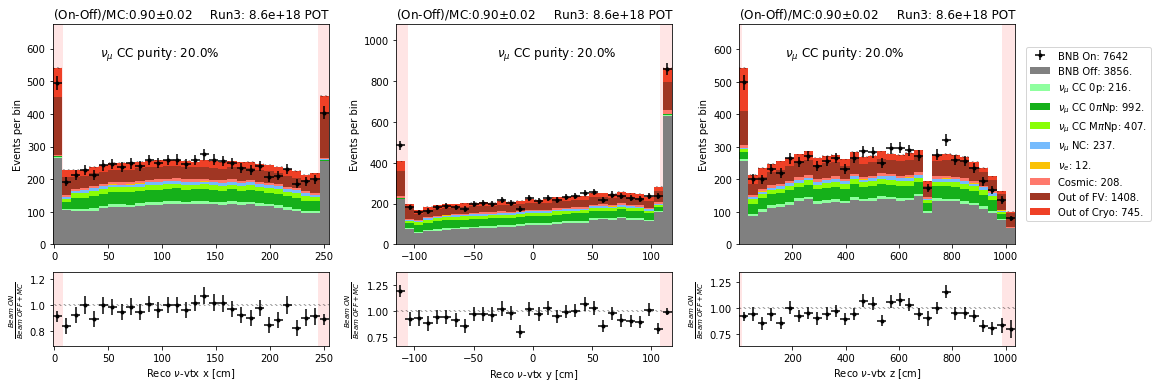

<IPython.core.display.Javascript object>

In [27]:
field = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
label = [r"Reco $\nu$-vtx x [cm]", r"Reco $\nu$-vtx y [cm]", r"Reco $\nu$-vtx z [cm]"]
legend = [False, False, True]

fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10 * plotter.gr, 5.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

for i in range(3):
    ax[0][i].axvspan(
        helper.tpc_box[i][0], helper.fid_box[i][0], facecolor="red", alpha=0.1
    )
    ax[0][i].axvspan(
        helper.fid_box[i][1], helper.tpc_box[i][1], facecolor="red", alpha=0.1
    )
    ax[1][i].axvspan(
        helper.tpc_box[i][0], helper.fid_box[i][0], facecolor="red", alpha=0.1
    )
    ax[1][i].axvspan(
        helper.fid_box[i][1], helper.tpc_box[i][1], facecolor="red", alpha=0.1
    )

    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[i],
        field[i],
        label[i],
        N_bins=30,
        x_min=helper.tpc_box[i][0],
        x_max=helper.tpc_box[i][1],
        query="daughter==0",
        legend=legend[i],
        title_str=title_str.split("NE")[-1],
        kind="cat",
        y_max_scaler=1.25,
    )

    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.6,
        ax[0][i].get_ylim()[1] * 0.85,
        r"$\nu_\mu$" + " CC purity: {0:<3.1f}%".format(purity * 100),
        horizontalalignment="right",
        fontsize=12,
    )


fig.tight_layout()
fig.savefig(output_dir + "thesis_recovtx_run{}.pdf".format(run), bbox_inches="tight")

MC category: $\nu_\mu$ CC 0p: 194. 	#entries 22405
MC category: $\nu_\mu$ CC 0$\pi$Np: 884. 	#entries 107336
MC category: $\nu_\mu$ CC M$\pi$Np: 304. 	#entries 46630
MC category: $\nu_\mu$ NC: 153. 	#entries 23333
MC category: $\nu_e$: 2.7 	#entries 12838
MC category: Cosmic: 106. 	#entries 16890
MC category: Out of FV: 302. 	#entries 41701
MC category: Out of Cryo: 168. 	#entries 5391


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $\nu_\mu$ CC 0p: 194. 	#entries 22405
MC category: $\nu_\mu$ CC 0$\pi$Np: 884. 	#entries 107336
MC category: $\nu_\mu$ CC M$\pi$Np: 304. 	#entries 46630
MC category: $\nu_\mu$ NC: 153. 	#entries 23333
MC category: $\nu_e$: 2.7 	#entries 12838
MC category: Cosmic: 106. 	#entries 16890
MC category: Out of FV: 302. 	#entries 41701
MC category: Out of Cryo: 168. 	#entries 5391
0.0


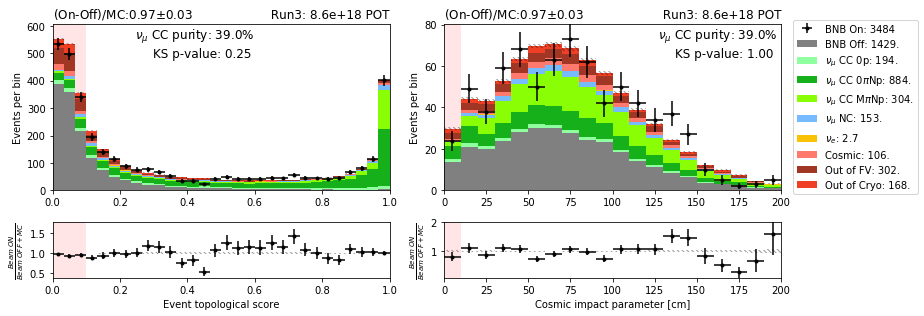

<IPython.core.display.Javascript object>

In [28]:
query = "(reco_fid_vol & slpdg==14 & all_start_contained & daughter == 0)"

fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ax[0][0].axvspan(0, 0.1, facecolor="red", alpha=0.1)
ax[1][0].axvspan(0, 0.1, facecolor="red", alpha=0.1)
ax[0][1].axvspan(0, 10, facecolor="red", alpha=0.1)
ax[1][1].axvspan(0, 10, facecolor="red", alpha=0.1)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "CosmicIP",
    r"Cosmic impact parameter [cm]",
    N_bins=20,
    x_min=0,
    x_max=200,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.99,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "thesis_presel_run{}.pdf".format(run), bbox_inches="tight")
print(ax[0][1].get_xlim()[1] * 0.0)

MC category: $p$: 1276. 	#entries 180908
MC category: $\mu$: 1417. 	#entries 177053
MC category: $e$: 4.1 	#entries 14755
MC category: $\pi^{\pm}$: 249. 	#entries 43122
MC category: $\gamma$: 200. 	#entries 33600
MC category: $K$: 1.1 	#entries 224
MC category: Cosmic: 810. 	#entries 111056


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $p$: 1276. 	#entries 180908
MC category: $\mu$: 1417. 	#entries 177053
MC category: $e$: 4.1 	#entries 14755
MC category: $\pi^{\pm}$: 249. 	#entries 43122
MC category: $\gamma$: 200. 	#entries 33600
MC category: $K$: 1.1 	#entries 224
MC category: Cosmic: 810. 	#entries 111056


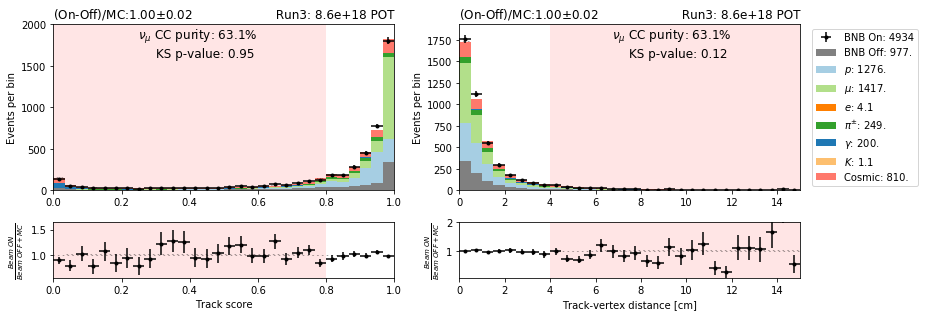

<IPython.core.display.Javascript object>

In [29]:
query = "(reco_fid_vol & slpdg==14 & all_start_contained & pfp_generation_v==2 & topological_score>0.1 & CosmicIP>10)"


fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ax[0][0].axvspan(0, 0.8, facecolor="red", alpha=0.1)
ax[1][0].axvspan(0, 0.8, facecolor="red", alpha=0.1)
ax[0][1].axvspan(4, 40, facecolor="red", alpha=0.1)
ax[1][1].axvspan(4, 40, facecolor="red", alpha=0.1)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_score_v",
    r"Track score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_distance_v",
    r"Track-vertex distance [cm]",
    N_bins=30,
    x_min=0,
    x_max=15,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.8,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "thesis_trk1_run{}.pdf".format(run), bbox_inches="tight")

MC category: $p$: 1039. 	#entries 146643
MC category: $\mu$: 1246. 	#entries 155990
MC category: $e$: 0.83 	#entries 3940
MC category: $\pi^{\pm}$: 179. 	#entries 30965
MC category: $\gamma$: 10. 	#entries 1701
MC category: $K$: 0.89 	#entries 174
MC category: Cosmic: 315. 	#entries 42417


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $p$: 1039. 	#entries 146643
MC category: $\mu$: 1246. 	#entries 155990
MC category: $e$: 0.83 	#entries 3940
MC category: $\pi^{\pm}$: 179. 	#entries 30965
MC category: $\gamma$: 10. 	#entries 1701
MC category: $K$: 0.89 	#entries 174
MC category: Cosmic: 315. 	#entries 42417


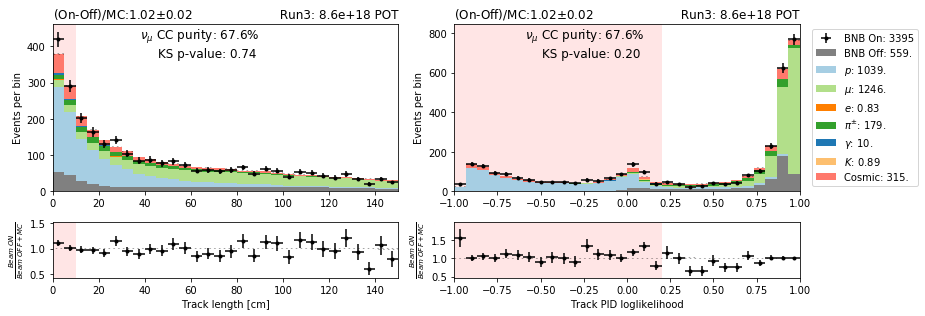

<IPython.core.display.Javascript object>

In [30]:
query = "(reco_fid_vol & slpdg==14 & all_start_contained & pfp_generation_v==2 & topological_score>0.1 & CosmicIP>10 & trk_score_v>0.8 & trk_distance_v<4)"


fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ax[0][0].axvspan(0, 10, facecolor="red", alpha=0.1)
ax[1][0].axvspan(0, 10, facecolor="red", alpha=0.1)
ax[0][1].axvspan(-1, 0.2, facecolor="red", alpha=0.1)
ax[1][1].axvspan(-1, 0.2, facecolor="red", alpha=0.1)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_len_v",
    r"Track length [cm]",
    N_bins=30,
    x_min=0,
    x_max=150,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_llr_pid_score_v",
    r"Track PID loglikelihood",
    N_bins=30,
    x_min=-1,
    x_max=1,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.1,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "thesis_trk2_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


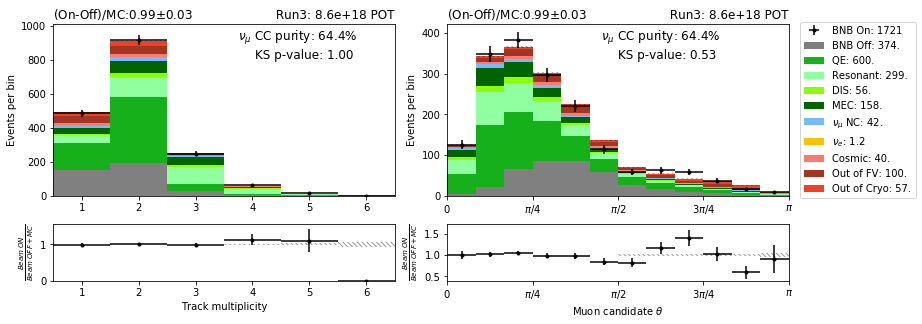

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "track_at_vtx",
    "Track multiplicity",
    N_bins=6,
    x_min=0.5,
    x_max=6.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "vtxntrack_int_run{}.pdf".format(run), bbox_inches="tight")


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.8,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(
    output_dir + "thesis_ntracks_theta_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:313: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:335: RuntimeWarning: invalid value encountered in true_divide
  y_min_r = max(0, min((bins[-1]-err_on)/val)*0.9)
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:336: RuntimeWarning: invalid value encountered in true_divide
  y_max_r = min(2, max((bins[-1]+err_on)/val)*1.1)
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:342: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:344: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


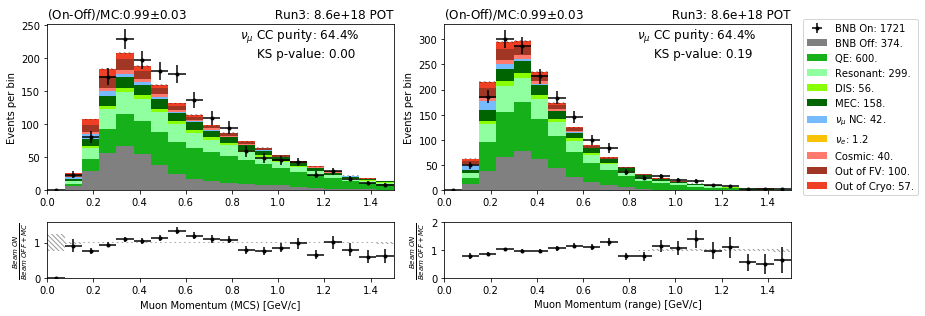

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=20,
    x_min=0.0,
    x_max=1.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_range_muon_mom_v",
    "Muon Momentum (range) [GeV/c]",
    N_bins=20,
    x_min=0.0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "thesis_momentum_run{}.pdf".format(run), bbox_inches="tight")

0 92729.24634206295 169089.10415539145 54.840462255241206
10 24456.5266777277 46737.34636712074 52.32758934497963
1 45756.0 85809.0 53.32307799881132


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:464: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


2 8700.0 20228.0 43.00968953925252


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:464: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:464: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


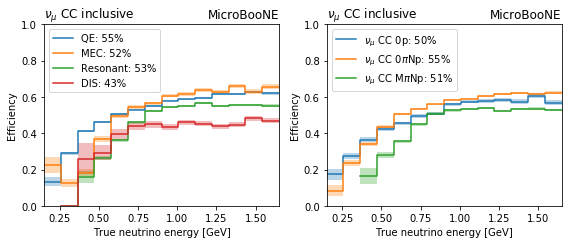

<IPython.core.display.Javascript object>

In [39]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))


cats = [0, 10, 1, 2]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("interaction==@cat")[field]
    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33").query("interaction==@cat")[
        "weightSplineTimesTune"
    ]

    print(cat, sum(num_w), sum(den_w), sum(num_w) / sum(den_w) * 100)
    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.int_labels_true[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[0].set_title(r"$\nu_\mu$ CC inclusive", loc="left")
ax[0].set_title(r"MicroBooNE", loc="right")
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].legend(loc="upper left")


cats = [30, 31, 32]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("category==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33").query("category==@cat")[
        "weightSplineTimesTune"
    ]
    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.category_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )

ax[1].set_title(r"$\nu_\mu$ CC inclusive", loc="left")
ax[1].set_title(r"MicroBooNE", loc="right")
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig(output_dir + "efficiency_run{}.pdf".format(run), bbox_inches="tight")


 MCS based momentum
0.2 	 0.20300023 	 [-0.04453576  0.03154346  0.35452892] 	 0.19953233785927316
0.2 	 0.2560002 	 [-0.05783203 -0.00363523  0.15599492] 	 0.10691347569227212
0.4 	 0.34099916 	 [-0.06330549 -0.01106617  0.11053646] 	 0.08692097514867783
0.4 	 0.4339984 	 [-0.07594925 -0.01647799  0.09751014] 	 0.08672969117760654
0.6 	 0.5269972 	 [-0.09747133 -0.02143848  0.08870541] 	 0.09308837056159973
0.6 	 0.6239973 	 [-0.11150943 -0.02588439  0.08384471] 	 0.09767706990242003
0.8 	 0.7179974 	 [-0.13242636 -0.03071082  0.08390948] 	 0.1081679210066795
0.8 	 0.8119975 	 [-0.16216978 -0.03926745  0.07341623] 	 0.11779300868511199
1.0 	 0.9049976 	 [-0.17196815 -0.04068574  0.07537392] 	 0.12367103695869444
1.0 	 0.9979977 	 [-0.22573718 -0.0500024   0.07856169] 	 0.15214943587779997
1.2 	 1.0920032 	 [-0.32097394 -0.05602837  0.06978569] 	 0.19537981450557707
1.2 	 1.1850083 	 [-0.37546235 -0.06127     0.05484629] 	 0.21515432000160217
1.4 	 1.2795081 	 [-0.33394928 -0.06310207

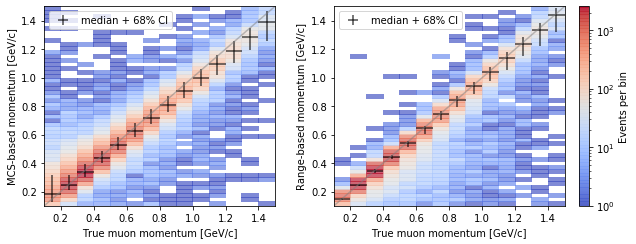

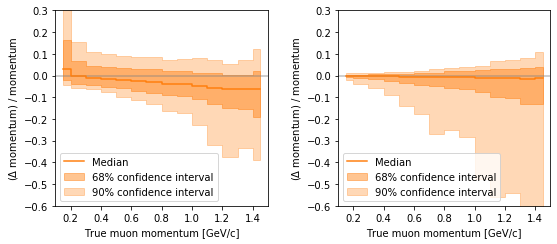

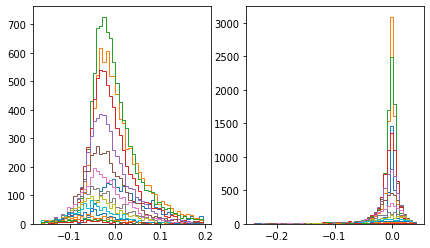

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3.5), gridspec_kw={"width_ratios": [4, 5]})
fig_res, ax_res = plt.subplots(ncols=2, figsize=(8, 3.5))
fig2, ax2 = plt.subplots(ncols=2, figsize=(7, 4))
n_x = 14
n_y = 50

print("\n MCS based momentum")
y_min = 0.1
y_max = 1.5

fld_mc = "backtracked_p"
fld_reco = "trk_mcs_muon_mom_v"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (y_min, y_max)),
)
ax[0].set_xlabel("True muon momentum [GeV/c]")
ax[0].set_ylabel("MCS-based momentum [GeV/c]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].plot([y_min, y_max], [y_min, y_max], color="grey", alpha=0.5)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")
ax_res[0].plot([y_min, y_max], [0, 0], color="grey", alpha=0.5)
ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True muon momentum [GeV/c]")
ax_res[0].set_ylabel(r"($\Delta$ momentum) / momentum")
ax_res[0].set_xlim(y_min, y_max)
ax_res[0].set_ylim(-0.6, 0.3)
ax_res[0].legend(loc="lower left")

print("\nRange Energy")
y_min = 0.1
y_max = 1.5
fld_mc = "backtracked_p"
fld_reco = "trk_range_muon_mom_v"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (y_min, y_max)),
)
ax[1].set_xlabel("True muon momentum [GeV/c]")
ax[1].set_ylabel("Range-based momentum [GeV/c]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[1]
)
ax[1].plot([y_min, y_max], [y_min, y_max], color="grey", alpha=0.5)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")
ax_res[1].plot([y_min, y_max], [0, 0], color="grey", alpha=0.5)
ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xlabel("True muon momentum [GeV/c]")
ax_res[1].set_ylabel(r"($\Delta$ momentum) / momentum")
ax_res[1].set_xlim(y_min, y_max)
ax_res[1].set_ylim(-0.6, 0.3)
ax_res[1].legend(loc="lower left")


clb = fig.colorbar(im, ax=ax[1])
clb.set_label("Events per bin", rotation=90)
fig.tight_layout()
fig.savefig(output_dir + "resolution.pdf")
fig_res.tight_layout()
fig_res.savefig(output_dir + "resolution_errors.pdf")

In [52]:
columns_map = [
    "topological_score",
    "trk_score_v",
    "trk_distance_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "",
    "trk_mcs_muon_mom_v",
    "trk_range_muon_mom_v",
    "trk_theta_v",
    "trk_phi_v",
    "",
    "backtracked_p",
    "backtracked_theta",
    "backtracked_phi",
]

daughters[""] = 0

map_labels = [
    "Topological score",
    "Track score",
    "Track vertex distance",
    "Track length",
    "Track PID likelihood",
    "",
    "MCS-based momentum",
    "Range-based momentum",
    r"Reconstructed $\theta$",
    r"Reconstructed $\phi$",
    "",
    "True momentum",
    r"True $\theta$",
    r"True $\phi$",
]

<IPython.core.display.Javascript object>

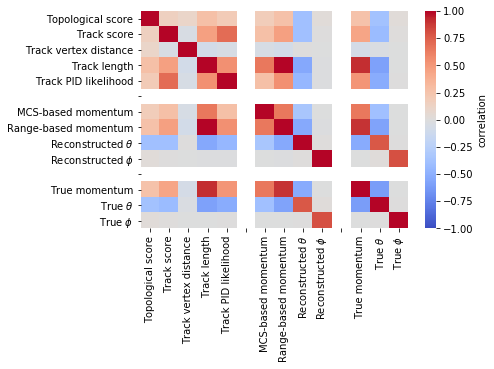

<IPython.core.display.Javascript object>

In [53]:
sns.heatmap(
    daughters[columns_map].corr(),
    cmap="coolwarm",
    xticklabels=map_labels,
    yticklabels=map_labels,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "correlation"},
)

plt.savefig(output_dir + "muon_corr.pdf", bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


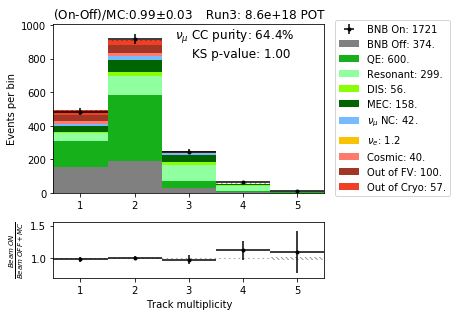

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "vtxntrack_int_run{}.pdf".format(run), bbox_inches="tight")

MC category: $\nu_\mu$ CC 0p: 144. 	#entries 16920
MC category: $\nu_\mu$ CC 0$\pi$Np: 710. 	#entries 87392
MC category: $\nu_\mu$ CC M$\pi$Np: 260. 	#entries 39862
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


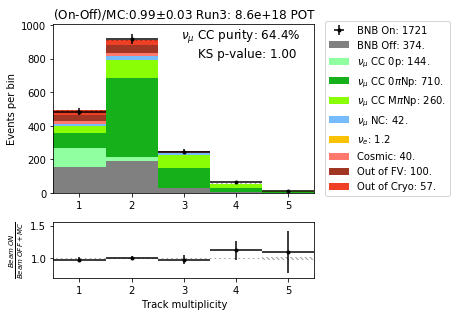

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.95,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "vtxntrack_cat_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


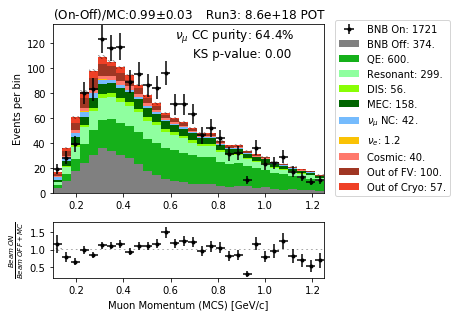

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=30,
    x_min=0.1,
    x_max=1.25,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "mcsmom_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:313: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyt

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ])

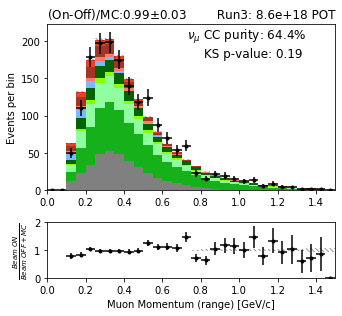

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax,
    "trk_range_muon_mom_v",
    "Muon Momentum (range) [GeV/c]",
    N_bins=30,
    x_min=0.0,
    x_max=1.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "rangemom_run{}.pdf".format(run), bbox_inches="tight")
bin_dict[2]

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


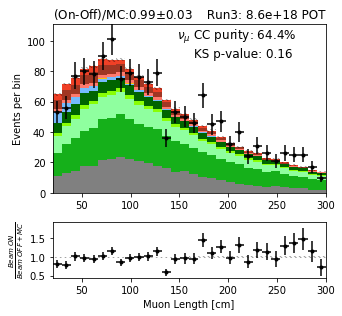

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax,
    "trk_len_v",
    "Muon Length [cm]",
    N_bins=30,
    x_min=20,
    x_max=300,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "trklen_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


array([-3.14159265, -2.93215314, -2.72271363, -2.51327412, -2.30383461,
       -2.0943951 , -1.88495559, -1.67551608, -1.46607657, -1.25663706,
       -1.04719755, -0.83775804, -0.62831853, -0.41887902, -0.20943951,
        0.        ,  0.20943951,  0.41887902,  0.62831853,  0.83775804,
        1.04719755,  1.25663706,  1.46607657,  1.67551608,  1.88495559,
        2.0943951 ,  2.30383461,  2.51327412,  2.72271363,  2.93215314,
        3.14159265])

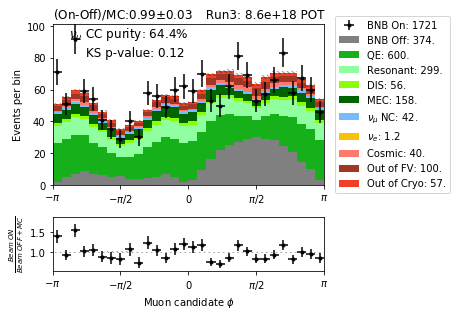

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax,
    "trk_phi_v",
    r"Muon candidate $\phi$",
    N_bins=30,
    x_min=-np.pi,
    x_max=np.pi,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.0,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "phi_run{}.pdf".format(run), bbox_inches="tight")
bin_dict[2]

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: QE: 192. 	#entries 21500
MC category: Resonant: 135. 	#entries 20799
MC category: DIS: 23. 	#entries 3597
MC category: MEC: 71. 	#entries 7245
MC category: $\nu_\mu$ NC: 33. 	#entries 5165
MC category: $\nu_e$: 0.90 	#entries 4602
MC category: Cosmic: 17. 	#entries 2770
MC category: Out of FV: 29. 	#entries 3902
MC category: Out of Cryo: 13. 	#entries 411
MC category: QE: 408. 	#entries 49704
MC category: Resonant: 164. 	#entries 25313
MC category: DIS: 33. 	#entries 5103
MC category: MEC: 87. 	#entries 10913
MC category: $\nu_\mu$ NC: 8.8 	#entries 1351
MC category: $\nu_e$: 0.29 	#entries 1590
MC category: Cosmic: 23. 	#entries 3600
MC category: Out of FV: 71. 	#entries 9771
MC category: Out of Cryo: 44. 	#entries 1411


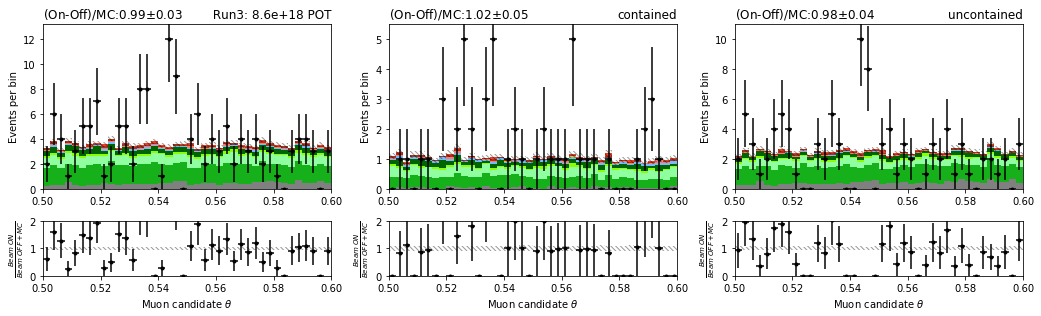

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(9 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=40,
    x_min=0.5,
    x_max=0.6,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=40,
    x_min=0.5,
    x_max=0.6,
    query="numuccinc_crt",
    legend=False,
    title_str="contained",
    kind="int",
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=40,
    x_min=0.5,
    x_max=0.6,
    query="(numuccinc & numuccinc_crt==0)",
    legend=False,
    title_str="uncontained",
    kind="int",
)


fig.tight_layout()
fig.savefig(output_dir + "test_david.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


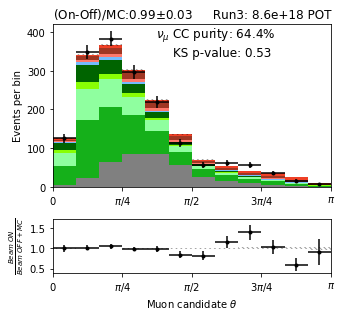

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax,
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=12,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.8,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "theta_run{}.pdf".format(run), bbox_inches="tight")

MC category: $\nu_\mu$ CC 0p: 185. 	#entries 21482
MC category: $\nu_\mu$ CC 0$\pi$Np: 1247. 	#entries 153485
MC category: $\nu_\mu$ CC M$\pi$Np: 483. 	#entries 74081
MC category: $\nu_\mu$ NC: 157. 	#entries 23933
MC category: $\nu_e$: 3.0 	#entries 14049
MC category: Cosmic: 110. 	#entries 17530
MC category: Out of FV: 285. 	#entries 39209
MC category: Out of Cryo: 151. 	#entries 4822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $p$: 667. 	#entries 95276
MC category: $\mu$: 1355. 	#entries 167394
MC category: $e$: 0.55 	#entries 3153
MC category: $\pi^{\pm}$: 157. 	#entries 27294
MC category: $\gamma$: 4.5 	#entries 745
MC category: $K$: 0.76 	#entries 152
MC category: Cosmic: 435. 	#entries 54577


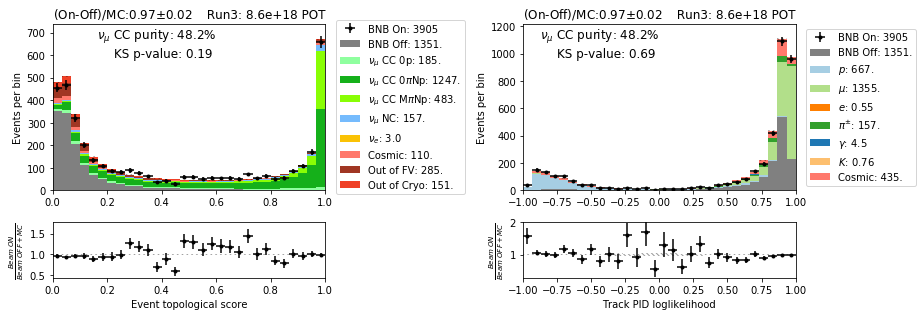

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][0]

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_llr_pid_score_v",
    r"Track PID loglikelihood",
    N_bins=30,
    x_min=-1,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.0,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


fig.tight_layout()
fig.savefig(output_dir + "pret_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


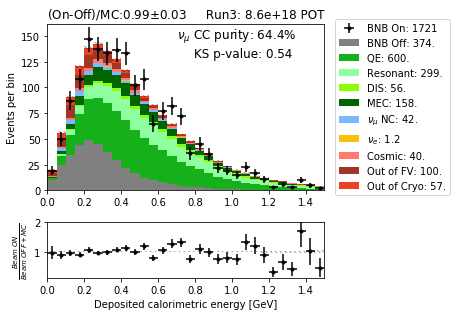

<IPython.core.display.Javascript object>

In [42]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "NeutrinoEnergy2/1000",
    "Deposited calorimetric energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "caloe_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:313: RuntimeWarning: invalid value encountered in double_scalars
  sc_err = e / v
/home/wouter/Documents/Jupyt

MC category: QE: 600. 	#entries 71204
MC category: Resonant: 299. 	#entries 46112
MC category: DIS: 56. 	#entries 8700
MC category: MEC: 158. 	#entries 18158
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


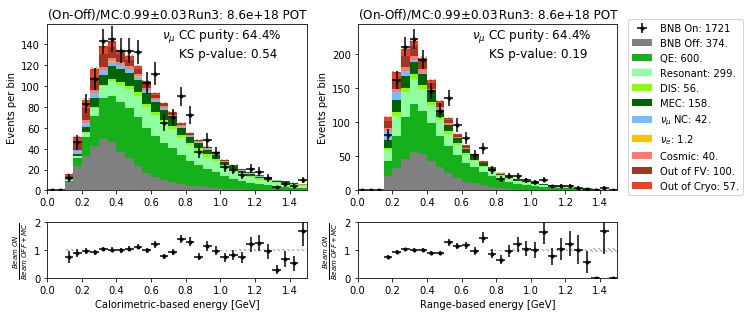

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(6.5 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "NeutrinoEnergy2/1000+0.106",
    "Calorimetric-based energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "range_based_tot_energy",
    "Range-based energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "caloe_rangevscalo_run{}.pdf".format(run), bbox_inches="tight")

MC category: $\nu_\mu$ CC 0p: 144. 	#entries 16920
MC category: $\nu_\mu$ CC 0$\pi$Np: 710. 	#entries 87392
MC category: $\nu_\mu$ CC M$\pi$Np: 260. 	#entries 39862
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:561: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:562: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $\nu_\mu$ CC 0p: 144. 	#entries 16920
MC category: $\nu_\mu$ CC 0$\pi$Np: 710. 	#entries 87392
MC category: $\nu_\mu$ CC M$\pi$Np: 260. 	#entries 39862
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822
MC category: $\nu_\mu$ CC 0p: 144. 	#entries 16920
MC category: $\nu_\mu$ CC 0$\pi$Np: 710. 	#entries 87392
MC category: $\nu_\mu$ CC M$\pi$Np: 260. 	#entries 39862
MC category: $\nu_\mu$ NC: 42. 	#entries 6516
MC category: $\nu_e$: 1.2 	#entries 6192
MC category: Cosmic: 40. 	#entries 6370
MC category: Out of FV: 100. 	#entries 13673
MC category: Out of Cryo: 57. 	#entries 1822


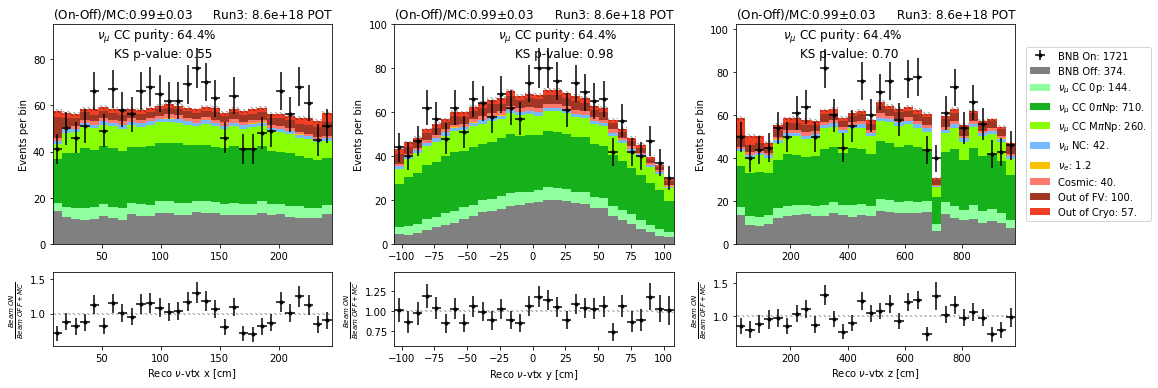

<IPython.core.display.Javascript object>

In [44]:
field = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
label = [r"Reco $\nu$-vtx x [cm]", r"Reco $\nu$-vtx y [cm]", r"Reco $\nu$-vtx z [cm]"]
legend = [False, False, True]

fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10 * plotter.gr, 5.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

for i in range(3):
    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[i],
        field[i],
        label[i],
        N_bins=30,
        x_min=helper.fid_box[i][0],
        x_max=helper.fid_box[i][1],
        query="numuccinc",
        legend=legend[i],
        title_str=title_str.split("NE")[-1],
        kind="cat",
        y_max_scaler=1.25,
    )

    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.6,
        ax[0][i].get_ylim()[1] * 0.85,
        r"$\nu_\mu$"
        + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
        horizontalalignment="right",
        fontsize=12,
    )


fig.tight_layout()
fig.savefig(output_dir + "recovtx_run{}.pdf".format(run), bbox_inches="tight")

In [45]:
# Fidvol ratio:
fidvol_vtx_old = [10, 10, 10, 10, 10, 50]
fidvol_vtx_new = [5, 5, 6, 6, 20, 50]

fv_old = 1
fv_new = 1

for i in range(3):
    fv_old *= (helper.upper[i] - fidvol_vtx_old[2 * i]) - (
        helper.lower[i] + fidvol_vtx_old[2 * i + 1]
    )
    fv_new *= (helper.upper[i] - fidvol_vtx_new[2 * i]) - (
        helper.lower[i] + fidvol_vtx_new[2 * i + 1]
    )

# Marco
fv_marco = (233 - 70) * (256.35 - 24) * (1036.8 - 25 - 100 - 85)

print(fv_new / fv_marco)
print(fv_new / fv_old)

1.6809342754712184
1.0703864950625397


<IPython.core.display.Javascript object>

# Done

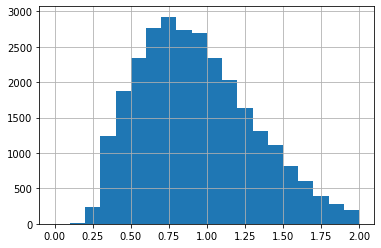

<IPython.core.display.Javascript object>

In [46]:
# Giusseppes request for true energy of calo energy
data["nu"]["daughters"].query("numuccinc & NeutrinoEnergy2<250")["nu_e"].hist(
    bins=20, range=(0, 2)
)

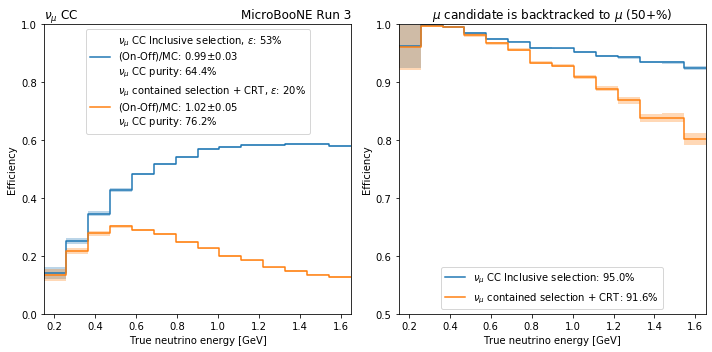

<IPython.core.display.Javascript object>

In [47]:
# eff per mode
field = "nu_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
labs = [r"$\nu_\mu$ CC Inclusive selection", r"$\nu_\mu$ contained selection + CRT"]


for q_s, lab in zip(["numuccinc", "numuccinc_crt"], labs):
    # get purity and ratio
    ratio, purity = plotter.get_ratio_and_purity(q_s)

    num = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]
    den = nu_df.query("category>29 & category<33")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33")["weightSplineTimesTune"]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label=r"{}, $\varepsilon$: {:.0%}".format(lab, sum(num_w) / sum(den_w))
        + "\n"
        + r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
        + "\n"
        + r"$\nu_\mu$ CC purity: {:.1%}".format(purity),
    )
    ax[0].set_title(r"$\nu_\mu$ CC", loc="left")
    ax[0].set_title("MicroBooNE Run 3", loc="right")
    ax[0].set_xlabel("True neutrino energy [GeV]")
    ax[0].set_ylabel("Efficiency")
    ax[0].set_ylim(0, 1)
    ax[0].set_xlim(x_min, x_max)
    ax[0].legend(loc="upper center")

    num = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")[field]
    )
    den = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")["weightSplineTimesTune"]
    )
    den_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{}: {:.1%}".format(lab, sum(num_w) / sum(den_w)),
    )
    ax[1].set_title(r"$\mu$ candidate is backtracked to $\mu$ (50+%)")
    ax[1].set_xlabel("True neutrino energy [GeV]")
    ax[1].set_ylabel("Efficiency")
    ax[1].set_ylim(0.5, 1)
    ax[1].set_xlim(x_min, x_max)
    ax[1].legend(loc="lower center")

fig.tight_layout()
fig.savefig(output_dir + "purity_run{}.pdf".format(run), bbox_inches="tight")

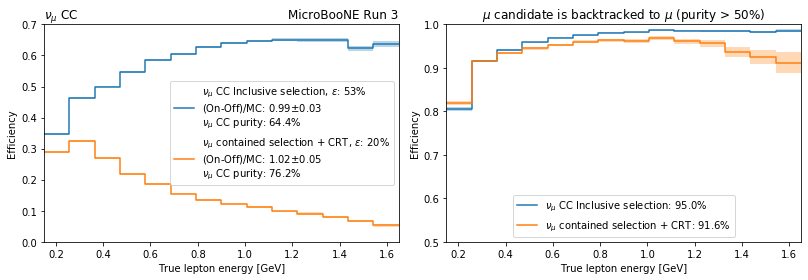

<IPython.core.display.Javascript object>

In [59]:
# eff per mode
field = "lep_e"
x_min = 0.15
x_max = 1.65
n_bins = 15
fig, ax = plt.subplots(ncols=2, figsize=(7 * plotter.gr, 4), sharex=True)
labs = [r"$\nu_\mu$ CC Inclusive selection", r"$\nu_\mu$ contained selection + CRT"]


for q_s, lab in zip(["numuccinc", "numuccinc_crt"], labs):
    # get purity and ratio
    ratio, purity = plotter.get_ratio_and_purity(q_s)

    num = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]
    den = nu_df.query("category>29 & category<33")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )
    den_w = nu_df.query("category>29 & category<33")["weightSplineTimesTune"]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label=r"{}, $\varepsilon$: {:.0%}".format(lab, sum(num_w) / sum(den_w))
        + "\n"
        + r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
        + "\n"
        + r"$\nu_\mu$ CC purity: {:.1%}".format(purity),
    )
    ax[0].set_title(r"$\nu_\mu$ CC", loc="left")
    ax[0].set_title("MicroBooNE Run 3", loc="right")
    ax[0].set_xlabel("True lepton energy [GeV]")
    ax[0].set_ylabel("Efficiency")
    ax[0].set_ylim(0, 0.7)
    ax[0].set_xlim(x_min, x_max)
    ax[0].legend(loc="center right")

    num = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")[field]
    )
    den = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")["weightSplineTimesTune"]
    )
    den_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSplineTimesTune"]
    )

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{}: {:.1%}".format(lab, sum(num_w) / sum(den_w)),
    )
    ax[1].set_title(r"$\mu$ candidate is backtracked to $\mu$ (purity > 50%)")
    ax[1].set_xlabel("True lepton energy [GeV]")
    ax[1].set_ylabel("Efficiency")
    ax[1].set_ylim(0.5, 1)
    ax[1].set_xlim(x_min, x_max)
    ax[1].legend(loc="lower center")

fig.tight_layout()
fig.savefig(output_dir + "muon_lepe_purity_run{}.pdf".format(run), bbox_inches="tight")

In [65]:
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc_crt")["backtracked_pdg"]
    .abs()
    .value_counts()
)
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc")["backtracked_pdg"]
    .abs()
    .value_counts()
    / len(data["nu"]["daughters"].query("category>29 & category<33").query("numuccinc"))
)

13      47910
211      3440
2212     1090
0         660
22         34
321         7
Name: backtracked_pdg, dtype: int64
13      0.942992
211     0.035325
2212    0.012735
0       0.008559
22      0.000305
321     0.000069
11      0.000014
Name: backtracked_pdg, dtype: float64


<IPython.core.display.Javascript object>

In [62]:
data["nu"]["daughters"]["mu_cand"] = data["nu"]["daughters"].eval(q_muon_select)
sums = (
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query(
        "reco_fid_vol & CosmicIP>10 & slpdg==14 & topological_score>0.1 & all_start_contained"
    )["mu_cand"]
    .groupby("event")
    .sum()
)
print(sums.value_counts() / len(sums) * 100)

1.0    76.363843
2.0    13.773647
0.0     8.903997
3.0     0.894696
4.0     0.063185
5.0     0.000632
Name: mu_cand, dtype: float64


<IPython.core.display.Javascript object>


Calo Energy
0.2 	 0.20583552 	 [-0.10741357 -0.05145603  0.03837667] 	 0.07289512176066637
0.3 	 0.25795892 	 [-0.1589537  -0.06906551  0.02279451] 	 0.09087410569190979
0.4 	 0.31728965 	 [-0.21150211 -0.08409286  0.02096819] 	 0.11623515188694
0.5 	 0.37517357 	 [-0.27980805 -0.10574833  0.0230472 ] 	 0.15142762660980225
0.6 	 0.42577454 	 [-0.34095464 -0.13347612  0.01941453] 	 0.18018458560109138
0.6 	 0.45533776 	 [-0.40376121 -0.18486387  0.01784563] 	 0.21080341935157773
0.7 	 0.49649552 	 [-0.47355708 -0.22401488  0.01139916] 	 0.24247812107205388
0.8 	 0.53317297 	 [-0.53496315 -0.2654461   0.01069847] 	 0.27283081114292135
0.9 	 0.56813526 	 [-0.60255239 -0.30982533  0.0092543 ] 	 0.3059033438563347
1.0 	 0.60487854 	 [-0.67498237 -0.3562879  -0.00639044] 	 0.33429596275091167

Range Energy
0.2 	 0.1854141727089882 	 [-0.0992903  -0.06981923 -0.03406275] 	 0.03261377289891243
0.3 	 0.22291063517332077 	 [-0.15804822 -0.09972762 -0.05006354] 	 0.053992340341210365
0.4 	 0.266

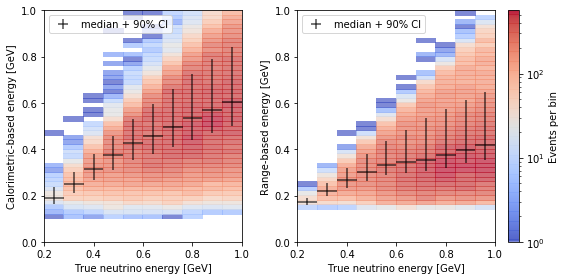

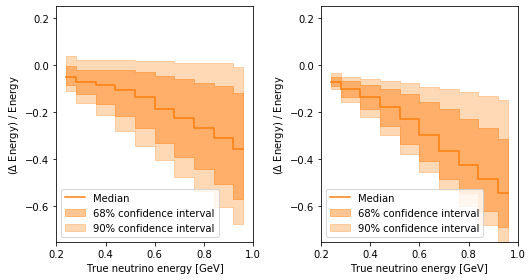

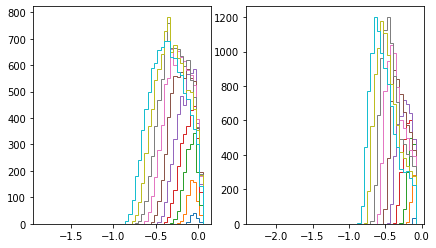

<IPython.core.display.Javascript object>

In [61]:
daughters = (
    data["nu"]["daughters"]
    .query("numuccinc")
    .query("category>29 & category<33")
    .query("abs(backtracked_pdg)==13")
)

fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw={"width_ratios": [4, 5]})
fig_res, ax_res = plt.subplots(ncols=2, figsize=(7.5, 4))
fig2, ax2 = plt.subplots(ncols=2, figsize=(7, 4))
n_x = 10
n_y = 50

print("\nCalo Energy")
y_min = 0.200
y_max = 1
fld_mc, fld_reco = "nu_e", "NeutrinoEnergy2/1000+0.106"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (0, y_max)),
)
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Calorimetric-based energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True neutrino energy [GeV]")
ax_res[0].set_ylabel(r"($\Delta$ Energy) / Energy")
ax_res[0].set_xlim(y_min, y_max)
ax_res[0].set_ylim(-0.75, 0.25)
ax_res[0].legend(loc="lower left")

print("\nRange Energy")
y_min = 0.200
y_max = 1
fld_mc, fld_reco = "nu_e", "range_based_tot_energy"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (0, y_max)),
)
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Range-based energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[1]
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")

ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xlabel("True neutrino energy [GeV]")
ax_res[1].set_ylabel(r"($\Delta$ Energy) / Energy")
ax_res[1].set_xlim(y_min, y_max)
ax_res[1].set_ylim(-0.75, 0.25)
ax_res[1].legend(loc="lower left")


clb = fig.colorbar(im, ax=ax[1])
clb.set_label("Events per bin", rotation=90)
fig.tight_layout()
fig.savefig(output_dir + "resolution.pdf")
fig_res.tight_layout()
fig_res.savefig(output_dir + "resolution_errors.pdf")

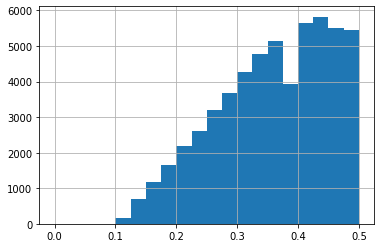

<IPython.core.display.Javascript object>

In [52]:
daughters["trk_energy_proton_v"].hist(bins=20, range=(0, 0.5))

In [53]:
def cosmic_angles(mom_x, mom_y, mom_z):
    theta = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_y)), mom_z)
    phi = np.arctan2(mom_y, mom_x)
    return [theta, phi]


cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

<IPython.core.display.Javascript object>


Energy
0.2 	 0.20436109602451324 	 [-0.02356714 -0.00120752  0.00836569] 	 0.01596641540527343
0.3 	 0.27115651965141296 	 [-0.07856871 -0.00285208  0.01062062] 	 0.044594667851924896
0.4 	 0.34248314797878265 	 [-0.15378775 -0.00678739  0.00980811] 	 0.08179793283343315
0.4 	 0.41156938672065735 	 [-0.2335542  -0.01991311  0.00990519] 	 0.12172969430685043
0.5 	 0.4647431969642639 	 [-0.31343636 -0.0658592   0.0109916 ] 	 0.16221398301422596
0.6 	 0.49194175004959106 	 [-0.39352857 -0.12326175  0.01148921] 	 0.20250888913869858
0.7 	 0.5248610973358154 	 [-0.46600615 -0.17540655  0.01316634] 	 0.23958624228835107
0.8 	 0.540604829788208 	 [-0.55165398 -0.24445295  0.01307673] 	 0.28236535377800465
0.9 	 0.5656293034553528 	 [-0.62298901 -0.30285832  0.01536244] 	 0.31917572394013405
1.0 	 0.5870551466941833 	 [-0.70483433 -0.36911964  0.01716796] 	 0.3610011413693428

Theta
9.0 	 0.23270349 	 [-3.31967561  0.43164062  7.02525802] 	 5.172466814517973
27.0 	 0.47180662 	 [-3.81217723  

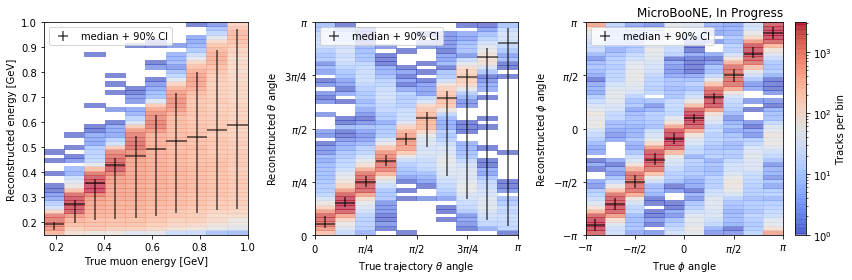

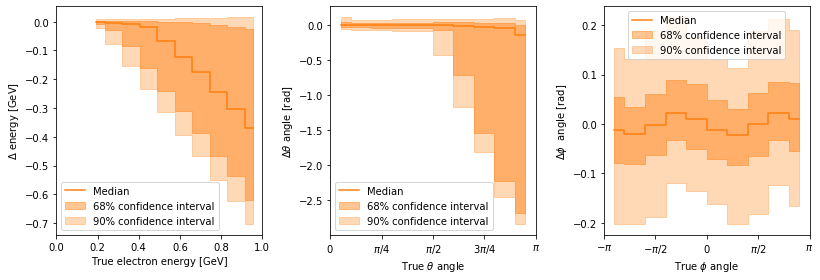

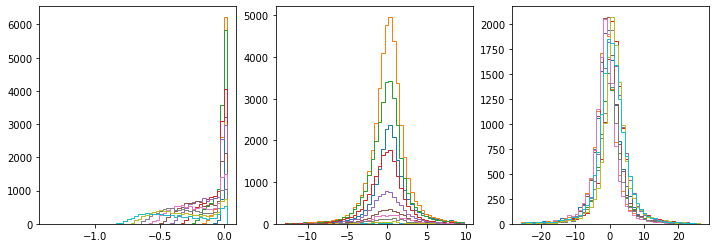

<IPython.core.display.Javascript object>

In [54]:
fig, ax = plt.subplots(
    ncols=3, figsize=(12, 4), gridspec_kw={"width_ratios": [4, 4, 4.85]}
)
fig_res, ax_res = plt.subplots(ncols=3, figsize=(11.5, 4))
fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
n_x = 10
n_y = 50

print("\nEnergy")
y_max = 1
fld_mc, fld_reco = "backtracked_e", "range_based_tot_energy"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((0.150, y_max), (0.150, y_max)),
)
ax[0].set_xlabel("True muon energy [GeV]")
ax[0].set_ylabel("Reconstructed energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True electron energy [GeV]")
ax_res[0].set_ylabel(r"$\Delta$ energy [GeV]")
ax_res[0].set_xlim(0, y_max)
ax_res[0].legend()

print("\nTheta")
fld_mc, fld_reco = "backtracked_theta", "trk_theta_v"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[1].set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax[1].set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax[1].set_yticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax[1].set_yticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax[1].set_xlabel(r"True trajectory $\theta$ angle")
ax[1].set_ylabel(r"Reconstructed $\theta$ angle")
ax[1].set_ylim(0, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[1], periodic=True
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")


ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xticks([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi])
ax_res[1].set_xticklabels([r"$0$", r"$\pi/4$", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
ax_res[1].set_xlabel(r"True $\theta$ angle")
ax_res[1].set_ylabel(r"$\Delta \theta$ angle [rad]")
ax_res[1].set_xlim(0, np.pi)
ax_res[1].legend()

print("\nPhi")
fld_mc, fld_reco = "backtracked_phi", "trk_phi_v"
h, x_edges, y_edges, im = ax[2].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="coolwarm",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[2].set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[2].set_xticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax[2].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax[2].set_yticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax[2].set_xlabel(r"True $\phi$ angle")
ax[2].set_ylabel(r"Reconstructed $\phi$ angle")
ax[2].set_ylim(-np.pi, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[2], periodic=True
)
ax[2].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 90% CI",
    alpha=0.7,
)
ax[2].legend(loc="upper left")
ax[2].set_title("MicroBooNE, In Progress", loc="right")

ax_res[2].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[2].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[2].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[2].set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax_res[2].set_xticklabels([r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax_res[2].set_xlabel(r"True $\phi$ angle")
ax_res[2].set_ylabel(r"$\Delta \phi$  angle [rad]")
ax_res[2].set_xlim(-np.pi, np.pi)
ax_res[2].legend(loc="upper center")

clb = fig.colorbar(im, ax=ax[2])
clb.set_label("Tracks per bin", rotation=90)
fig.tight_layout()
fig_res.tight_layout()
fig.savefig(output_dir + "resolution.pdf")
fig_res.savefig(output_dir + "resolution_errors.pdf")
fig2.savefig(output_dir + "resolution_shapes.pdf")